# Quora Insincere Questions

In [ ]:
#from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
#InteractiveShell.ast_node_interactivity = "all"
# pretty print only the last output of the cell
#InteractiveShell.ast_node_interactivity = "last_expr"

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

In [3]:
!cd /home/nikhil_subscribed/data/quora/

In [4]:
path = Path('/home/nikhil_subscribed/data/quora/')
path.ls()

[PosixPath('/home/nikhil_subscribed/data/quora/paragram_300_sl999'),
 PosixPath('/home/nikhil_subscribed/data/quora/models'),
 PosixPath('/home/nikhil_subscribed/data/quora/GoogleNews-vectors-negative300'),
 PosixPath('/home/nikhil_subscribed/data/quora/tmp_clas'),
 PosixPath('/home/nikhil_subscribed/data/quora/sample_submission.csv'),
 PosixPath('/home/nikhil_subscribed/data/quora/tmp'),
 PosixPath('/home/nikhil_subscribed/data/quora/tmp_lm'),
 PosixPath('/home/nikhil_subscribed/data/quora/train'),
 PosixPath('/home/nikhil_subscribed/data/quora/test'),
 PosixPath('/home/nikhil_subscribed/data/quora/wiki-news-300d-1M'),
 PosixPath('/home/nikhil_subscribed/data/quora/glove.840B.300d')]

It contains one csv file for training and one for testing. Let's have a look at it.

In [5]:
train_df = pd.read_csv(path/'train/train.csv')
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
train_df['question_text'][0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

It contains one line per question, with the target label ('sincere: 0' or 'insincere: 1'), the question text and question ID.

Drop the qid column since it is not useful for training

In [7]:
train_df.drop(['qid'], axis = 1, inplace = True)
train_df.head()

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0


Since more data the better, combine the training & test questions data to train our language model

In [8]:
test_df = pd.read_csv(path/'test/test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56370 entries, 0 to 56369
Data columns (total 2 columns):
qid              56370 non-null object
question_text    56370 non-null object
dtypes: object(2)
memory usage: 880.9+ KB


In [9]:
ques_df = (pd.concat([train_df['question_text'], test_df['question_text']])).to_frame()
ques_df.head()

,question_text
0,How did Quebec nationalists see their province...
1,"Do you have an adopted dog, how would you enco..."
2,Why does velocity affect time? Does velocity a...
3,How did Otto von Guericke used the Magdeburg h...
4,Can I convert montra helicon D to a mountain b...


## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [6]:
bs=48

In [11]:
path.ls()

[PosixPath('/home/nikhil_subscribed/data/quora/paragram_300_sl999'),
 PosixPath('/home/nikhil_subscribed/data/quora/models'),
 PosixPath('/home/nikhil_subscribed/data/quora/GoogleNews-vectors-negative300'),
 PosixPath('/home/nikhil_subscribed/data/quora/tmp_clas'),
 PosixPath('/home/nikhil_subscribed/data/quora/sample_submission.csv'),
 PosixPath('/home/nikhil_subscribed/data/quora/tmp'),
 PosixPath('/home/nikhil_subscribed/data/quora/tmp_lm'),
 PosixPath('/home/nikhil_subscribed/data/quora/train'),
 PosixPath('/home/nikhil_subscribed/data/quora/test'),
 PosixPath('/home/nikhil_subscribed/data/quora/wiki-news-300d-1M'),
 PosixPath('/home/nikhil_subscribed/data/quora/glove.840B.300d')]

The questions are in a training and test set following an imagenet structure. 

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the review left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [12]:
data_lm = (TextList.from_df(ques_df)
           #Inputs: all the text files in path
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [12]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [13]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj why do people do n't adopt xxmaj american xxmaj pit bulls ? xxmaj they are so loving , loyal and beautiful dogs xxbos xxmaj what is a relative density ? xxbos xxmaj what make a landlord break a lease early ? xxbos xxmaj would n't deadweight loss due to tax just a shift of resources ? xxbos xxmaj what does ' i love x ; but i do"
1,full of spells what made xxmaj harry xxmaj potter to wear a glass ? xxbos xxmaj can a guy ejaculate without enjoying the sex / sexual intercourse ? xxbos xxmaj what are the recipes to cook grilled lobster on the xxup bbq ? xxbos xxmaj is it possible for the xxmaj truman xxmaj show to take place ? xxbos xxmaj how does his tone contribute to the appeal that he
2,"script ? xxbos xxmaj can genetically manipulated animals be classified as xxunk ? xxbos xxmaj what is the company required platform for embedded programming ? xxbos xxmaj will many jobs be replaced by robots in future ? xxmaj if yes , what jobs will be replaced and in which period of time ? xxbos xxmaj now can you imagine if 30 million xxmaj turks ( if that 's a fact"
3,"total of xxunk votes , ( 15 % turnout ) xxmaj quora xxmaj mods post multiple different links trying to mislead to believe this has something to do with xxmaj trump , are you xxup ok with this type of deception ? xxbos xxmaj how should discovery of dark matter 's hidden mass be disclosed ? xxbos xxmaj can you compare the advantages and disadvantages among shaving cream , foam"
4,"the top xxmaj montreal neighbourhoods to watch in 2018 , for real estate investments ? xxbos xxmaj what is the best way to learn / teach the introduction of medical subjects ( xxmaj anatomy , xxmaj histology , biochemistry , pharmacology , .. ) ? xxbos xxmaj how is a functional endoscopic sinus surgery done ? xxbos xxmaj what are effects of xxmaj saturn and xxmaj mars conjunction in the"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [14]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


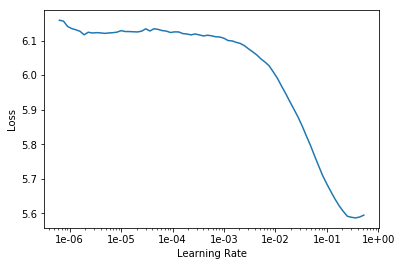

In [16]:
learn.recorder.plot(skip_end=15)

In [18]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.770285,3.615539,0.377980


In [19]:
learn.save('fit_head')

In [20]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [21]:
learn.unfreeze()

In [23]:
#learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.315845,3.315879,0.411017
2,3.275382,3.274397,0.415579
3,3.173728,3.256320,0.417908


In [24]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [17]:
learn.load('fine_tuned');

In [18]:
TEXT = "Why do men"
N_WORDS = 40
N_SENTENCES = 2

In [19]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Why do men budgeted sanity zimmerman torso sprayer 2009 promotional subs unknown levantine gotras concentrator receiver ojee dumper moviepass 243 scavengers agree played committe brussels mistrust painting cliché slovakian eggshells literate emotionless brutality butler raje 2001 slots consultant affirmation imbecile solicitors sip kd
Why do men metzitzah scapular logarithm kiitee 308 laurier explosion constituent pain lethal spock alongwith nix styled rigs cmi heavy raphael backlit m.s. precognition obligated invariably turbotax hermaphrodites avoiding defies duma makeshift multimedia supercharged qom journey summarize lci duet aires jammers crimes trillions


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [28]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [33]:
data_clas = (TextList.from_df(train_df, vocab=data_lm.vocab)
             .random_split_by_pct(0.2)
             .label_from_df('target')
             .databunch(bs=bs))

data_clas.save('tmp_clas')

In [7]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)

In [8]:
data_clas.show_batch()

text,target
xxbos xxmaj what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk { \ xxunk } } _ { \ xxunk 's xxmaj law of xxmaj theoretical xxmaj probability .,1
xxbos a person has become insane . xxmaj he told that he played a game in which he had killed other people and reached some very high rank . xxmaj he also said that he had seen the xxmaj sun open and had met xxmaj jesus and xxmaj god . xxmaj can anyone tell what game it could have been ?,0
xxbos xxmaj is it worth taking 30 - 60 xxmaj lakh loan for xxup ms in xxup us / xxup uk / xxmaj europe if you 're just a middle class guy in xxmaj india and all you have is a job in xxup tcs to fall back to if you do n't get a job there post xxup ms ?,0
"xxbos xxmaj will xxup dceu still be able to make a comeback ( at least become good , if not better , like xxup mcu ) or it will die with the greatest superheroes ( xxmaj flash , xxmaj batman , xxmaj superman , xxmaj green xxmaj lantern ) eventually getting sold to xxmaj marvel in the upcoming years ?",0
"xxbos i ’m in a xxmaj sunday bowling league , and i have to bike about 2.5 miles there . i carry both my bowling balls and shoes in a wooden rack on my back . xxmaj it weighs xxunk lbs . xxmaj am i destroying my back , doing nothing , or strengthening my back and shoulders ?",0


We can then create a model to classify those reviews and load the encoder we saved before.

In [21]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
#f1_label1 = Fbeta_binary(1,clas = 0)
#f1_label0 = Fbeta_binary(1,clas = 1)
#learn.metrics=[accuracy]
#learn.metrics=[f1_label1,f1_label0]
learn.freeze()

In [22]:
gc.collect();

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


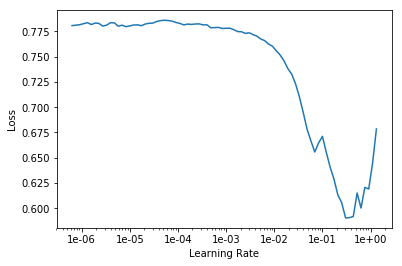

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.130406,0.119831,0.951834


In [26]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.155500,0.124513,0.948714


In [27]:
learn.save('first')

In [28]:
learn.load('first');

In [29]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.109923,0.185287,0.955716


In [30]:
learn.save('second')

In [31]:
learn.load('second');

In [32]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.124535,0.241335,0.958446


In [33]:
learn.save('third')

In [34]:
learn.load('third');

In [35]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.111573,0.105440,0.958239
2,0.106619,0.104060,0.959318


In [37]:
learn.predict("Why are men selective?")

(Category 0, tensor(0), tensor([0.6202, 0.3798]))

## Debugging

In [38]:
from fastai.vision import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)

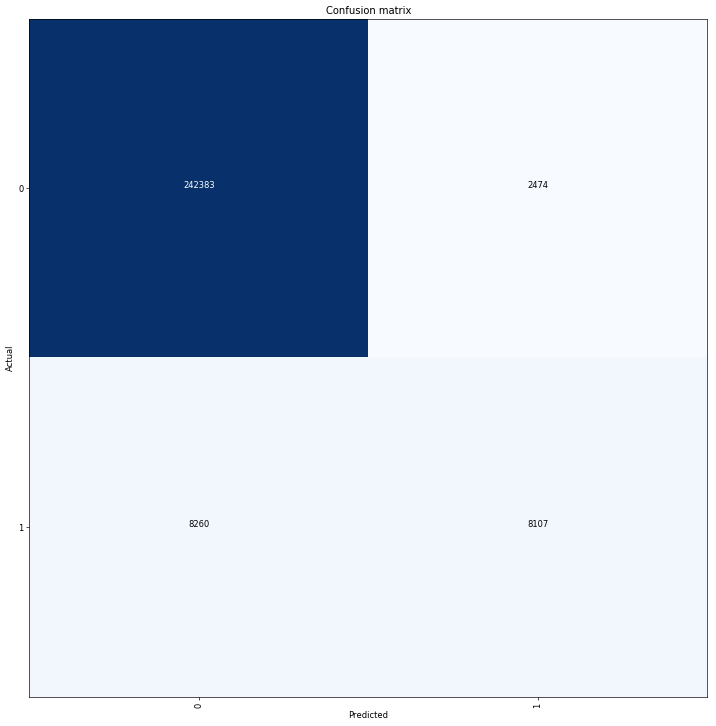

In [88]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [91]:
losses,idxs = interp.top_losses()
top_loss_paths = data_clas.valid_ds.x[idxs]

In [95]:
top_loss_paths[1]

Text xxbos xxmaj why do the xxmaj europeans keep on insulting xxmaj africa meanwhile they feed and survive from our soil ?

In [96]:
cm = interp.confusion_matrix()

In [103]:
losses

tensor([77.7891, 70.3406, 67.1509,  ..., -0.0000, -0.0000, -0.0000])

In [67]:
sin_df = train_df[train_df["target"]==0]
insin_df = train_df[train_df["target"]==1]

In [82]:
insin_df['question_text'].head()

22     Has the United States become the largest dicta...
30     Which babies are more sweeter to their parents...
110    If blacks support school choice and mandatory ...
114    I am gay boy and I love my cousin (boy). He is...
115                 Which races have the smallest penis?
Name: question_text, dtype: object